In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pde
from sklearn.preprocessing import StandardScaler, Normalizer
import warnings
import pandas as pd

from KO_PDE_FIND import *

warnings.filterwarnings('ignore')

# EQL for mean sister position when $\sigma = (+,-)$

In [3]:
# Load the data from the mean_position histogram (+- state)

Pt = np.load('../Data/mean_position_+-.npy') # load data obtained from binning the trajectories

# Build matrix library

In [4]:
# time_diff : determines how temporal derivatives are denoised. Options: Finite Difference and polynomila interpolation
# space_diff: determines how spatial derivates are denoised
# dt, dx are temporal and spatial step sizes
# deg_x, deg_t : degree of x and t for polynomial interpolation
# Pt : Empirical distribution for the +- state


dPt,R,rhs_des = build_linear_system(Pt, dt=1.0, dx=1.0, D=2, P=3, time_diff = 'poly', space_diff='poly', deg_x = 10, deg_t=3)

# EQL library 1: $[1, P, P_x, xP_x, P_{xx}]$

In [5]:
# Construct Theta to preserve the FPE with the suitable candidate terms


x = np.linspace(-3,3,150)
trim = x[15:-15] # Poly interpolation trims of 30 boundary points while using build_linear_system function
trim_x = np.tile(trim,23)
trim_x.shape

(2760,)

In [6]:
# Theta columns

col_1s = R[:,0] # column of 1s
col_x = trim_x # col of x
col_x_2 = np.power(trim_x,2) # col of x**2
col_p = R[:, 1] # column p
col_p_x = R[:,4] # column p_x
col_xp_x = np.multiply(col_x,col_p_x) # column xp_x
col_x2_p_x = np.multiply(col_x_2,col_p_x) # col x**2 * p_x
col_p_xx = R[:,8]


col1 = col_1s
col2 = col_p_x
col3 = col_xp_x + col_p
col4 = 0.5*(np.multiply(np.power(col_x,2),col_p_x)) + np.multiply(col_x,col_p)
col5 = col_p_xx
# Theta
Theta = np.column_stack((col_1s,col_p, col_p_x, col_xp_x, col_p_xx))

# Theta = np.column_stack((col1,col2,col3,col4,col5))

Theta.shape
fpe_rhs_desc = ['','p','p_{x}','xp_{x}','p_{xx}']

# fpe_rhs_desc = ['', 'p_{x}', 'xp_{x}+p', 'x^2 + xp', 'p_{xx}']
fpe_rhs_desc

['', 'p', 'p_{x}', 'xp_{x}', 'p_{xx}']

In [7]:
w = TrainSTRidge(Theta,dPt,0.01,0.1,maxit=50,STR_iters=10,print_best_tol=False,normalize=2)
print_pde(w,fpe_rhs_desc)

u_t = (-0.042989 +0.000000i)p
    + (0.066545 +0.000000i)p_{x}
    + (-0.009899 +0.000000i)p_{xx}
   


In [23]:
# stack the col vectors to form theta

Theta = np.column_stack((col_1s,col_p,col_p_x,col_xp_x,col_p_xx))

# train stridge

w = TrainSTRidge(Theta,dPt,0.05,0.1,maxit=50,STR_iters=10,print_best_tol=True,normalize=2)
print_pde(w,fpe_rhs_desc)

Optimal tolerance: 4.999999999999998
u_t = (-0.042989 +0.000000i)p
    + (0.066545 +0.000000i)p_{x}
    + (-0.009899 +0.000000i)p_{xx}
   


In [10]:
# compute aic scores

AIC = []
for dx in np.linspace(1,2,10):
    for dt in np.linspace(1,2,10):
        if dx ==0. or dt ==0.:
            continue
        dPt,R,rhs_des = build_linear_system(Pt, dt=3, dx=dx, D=2, P=2, time_diff = 'poly', 
                                            space_diff='poly', deg_x = 10, deg_t=3)
        # Theta columns
        
        col_1s = R[:,0] # column of 1s
        col_p = R[:, 1] # column p
        col_p_x = R[:,3] # column p_x
        col_xp_x = np.multiply(trim_x,col_p_x) # column xp_x
        col_p_xx = R[:,6]

        # Theta
        Theta = np.column_stack((col_1s,col_p, col_p_x, col_xp_x, col_p_xx))

    #     Theta.shape

        ptrain, ptest, dPt_train, dPt_test = split_data(Theta,dPt,0.8)

        w = TrainSTRidge(Theta,dPt,0.0001,0,maxit=25,STR_iters=50,print_best_tol=True,normalize=2)

        c1 = round(w[0].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c2 = round(w[1].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c3 = round(w[2].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c4 = round(w[3].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c5 = round(w[4].real[0],4)# Extract the sparse vectors to simulate the learned model.

        new_model = learned_model(c1,c2,c3,c4,c5)
        new_model = np.array(new_model)
        new_model = new_model[2:-3,15:-15].reshape(len(dPt),1)
        scaler = StandardScaler()
#         normalizer=Normalizer()
        new_model=scaler.fit_transform(new_model)
#         new_model=normalizer.fit_transform(new_model)
        aic_score = aic(new_model,dPt.real,k=len(w)) # calculate the aic with the test data %set_env
#         if np.nan in new_model:
#             print("nan here!!!")
#             print(dx,"\n ============"dt,w)
        if aic_score < 10:
            break

        print(aic_score)
        AIC.append([aic_score,dx,dt])

Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

432.02922574607436
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

432.02922574607436
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

432.02922574607436
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

432.02922574607436
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

432.02922574607436
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

432.02922574607436
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

432.02922574607436
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

432.02922574607436
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

432.02922574607436
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

432.02922574607436
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

430.7801915562142
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

430.7801915562142
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

430.7801915562142
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

430.7801915562142
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

430.7801915562142
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

430.7801915562142
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

430.7801915562142
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

430.7801915562142
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

430.7801915562142
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

430.7801915562142
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

429.70327779480584
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

429.70327779480584
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

429.70327779480584
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

429.70327779480584
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

429.70327779480584
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

429.70327779480584
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

429.70327779480584
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

429.70327779480584
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

429.70327779480584
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

429.70327779480584
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

428.8214405403707
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

428.8214405403707
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

428.8214405403707
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

428.8214405403707
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

428.8214405403707
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

428.8214405403707
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

428.8214405403707
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

428.8214405403707
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

428.8214405403707
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

428.8214405403707
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 0.0


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726


In [26]:
# display results in dataframe

pd.DataFrame(AIC,columns=['AIC Score','dx','dt'])

,AIC Score,dx,dt
0,432.029226,1.0,1.000000
1,432.029226,1.0,1.111111
2,432.029226,1.0,1.222222
3,432.029226,1.0,1.333333
4,432.029226,1.0,1.444444
...,...,...,...
95,81.357925,2.0,1.555556
96,81.357925,2.0,1.666667
97,81.357925,2.0,1.777778
98,81.357925,2.0,1.888889


# EQL library 2 : $[1, P_{x}, xP_{x}+P, x^2 + xP, P_{xx}$

In [98]:
col1 = col_1s
col2 = col_p_x
col3 = col_xp_x + col_p
col4 = 0.5*(np.multiply(np.power(col_x,2),col_p_x)) + np.multiply(col_x,col_p)
col5 = col_p_xx

# Theta
# Stack the columns
Theta = np.column_stack((col_1s,col_p, col_p_x, col_xp_x, col_p_xx))

fpe_rhs_desc = ['', 'p_{x}', 'xp_{x}+p', 'x^2 + xp', 'p_{xx}']
fpe_rhs_desc

['', 'p_{x}', 'xp_{x}+p', 'x^2 + xp', 'p_{xx}']

In [99]:
# train stridge

w = TrainSTRidge(Theta,dPt,0.005,0.1,maxit=50,STR_iters=10,print_best_tol=True,normalize=2)
print_pde(w,fpe_rhs_desc)

Optimal tolerance: 4.999999999999998
u_t = (0.019181 +0.000000i)p_{x}
    + (-0.040225 +0.000000i)xp_{x}+p
    + (0.018736 +0.000000i)p_{xx}
   


In [25]:
# compute aic scores

Model = []
AIC = []
for dx in np.linspace(1,2,10):
    for dt in np.linspace(1,2,10):
        if dx ==0. or dt ==0.:
            continue
        dPt,R,rhs_des = build_linear_system(Pt, dt=3.0, dx=dx, D=2, P=2, time_diff = 'poly', 
                                            space_diff='poly', deg_x = 10, deg_t=3)
        # Theta columns

        col_1s = R[:,0] # column of 1s
        col_p = R[:, 1] # column p
        col_p_x = R[:,3] # column p_x
        col_xp_x = np.multiply(trim_x,col_p_x) # column xp_x
        col_p_xx = R[:,6]

        # Theta
        Theta = np.column_stack((col_1s,col_p, col_p_x, col_xp_x, col_p_xx))

    #     Theta.shape

        ptrain, ptest, dPt_train, dPt_test = split_data(Theta,dPt,0.8)

        w = TrainSTRidge(Theta,dPt,0.005,0.1,maxit=25,STR_iters=50,print_best_tol=True,normalize=2)
 
        c1 = round(w[0].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c2 = round(w[1].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c3 = round(w[2].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c4 = round(w[3].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c5 = round(w[4].real[0],4)# Extract the sparse vectors to simulate the learned model.

        new_model = learned_model(c1,c2,c3,c4,c5)
        new_model = np.array(new_model)
        new_model = new_model[2:-3,15:-15].reshape(2760,1)
        scaler = StandardScaler()
        normalizer=Normalizer()
        new_model=scaler.fit_transform(new_model)
        new_model=normalizer.fit_transform(new_model)
        aic_score = aic(new_model,dPt.real,k=len(w)) # calculate the aic with the test data %set_env
#         if np.nan in new_model:
#             print("nan here!!!")
#             print(dx,"\n ============"dt,w)
        if aic_score < 10:
            break

        print(aic_score)
        AIC.append(aic_score)

Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

421.2748928274915
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

421.2748928274915
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

421.2748928274915
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

421.2748928274915
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

421.2748928274915
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

421.2748928274915
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

421.2748928274915
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

421.2748928274915
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

421.2748928274915
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

421.2748928274915
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

425.1668183156806
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

425.1668183156806
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

425.1668183156806
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

425.1668183156806
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

425.1668183156806
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

425.1668183156806
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

425.1668183156806
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

425.1668183156806
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

425.1668183156806
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

425.1668183156806
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

426.56991303110533
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

426.56991303110533
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

426.56991303110533
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

426.56991303110533
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

426.56991303110533
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

426.56991303110533
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

426.56991303110533
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

426.56991303110533
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

426.56991303110533
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

426.56991303110533
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

431.6022190286655
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

431.6022190286655
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

431.6022190286655
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

431.6022190286655
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

431.6022190286655
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

431.6022190286655
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

431.6022190286655
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

431.6022190286655
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

431.6022190286655
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

431.6022190286655
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726
Optimal tolerance: 2.500000000000001


  0%|          | 0/27.0 [00:00<?, ?it/s]

81.35792538528726


In [21]:
Pt.shape

(27, 150)

In [26]:
pd.DataFrame(AIC,columns=['AIC Score'])

,AIC Score
0,421.274893
1,421.274893
2,421.274893
3,421.274893
4,421.274893
...,...
95,81.357925
96,81.357925
97,81.357925
98,81.357925


# EQL for the mean position when $\sigma = (-,+)$

In [3]:
# Load the data from the mean_position histogram (+- state)

Pt = np.load('../Data/mean_position_mp.npy') # load data obtained from binning the trajectories

# Build the library

In [4]:
dPt,R,rhs_des = build_linear_system(Pt, dt=2.0, dx=1.0, D=2, P=3, time_diff = 'poly', space_diff='poly', deg_x = 10, deg_t=3)

In [5]:
# Construct Theta to preserve the FPE with the suitable candidate terms


x = np.linspace(-3,3,150)
trim = x[15:-15] # Poly interpolation trims off 30 boundary points while using build_linear_system function
trim_x = np.tile(trim,19)
trim_x.shape

(2280,)

# EQL library 1: $[1, P, P_x, xP_x, P_{xx}]$

In [6]:
# Theta columns

col_1s = R[:,0] # column of 1s
col_x = trim_x # col of x
col_x_2 = np.power(trim_x,2) # col of x**2
col_p = R[:, 1] # column p
col_p_x = R[:,4] # column p_x
col_xp_x = np.multiply(col_x,col_p_x) # column xp_x
col_x2_p_x = np.multiply(col_x_2,col_p_x) # col x**2 * p_x
col_p_xx = R[:,8]


col1 = col_1s
col2 = col_p_x
col3 = col_xp_x + col_p
col4 = 0.5*(np.multiply(np.power(col_x,2),col_p_x)) + np.multiply(col_x,col_p)
col5 = col_p_xx
# Theta
Theta = np.column_stack((col_1s,col_p, col_p_x, col_xp_x, col_p_xx))

# Theta = np.column_stack((col1,col2,col3,col4,col5))

Theta.shape
fpe_rhs_desc = ['','p','p_{x}','xp_{x}','p_{xx}']

# fpe_rhs_desc = ['', 'p_{x}', 'xp_{x}+p', 'x^2 + xp', 'p_{xx}']
fpe_rhs_desc

ValueError: operands could not be broadcast together with shapes (2280,) (2040,) 

In [11]:
Pt.shape

(21, 150)

In [139]:
w = TrainSTRidge(Theta,dPt,0.01,0.1,maxit=50,STR_iters=10,print_best_tol=True,normalize=2)
print_pde(w,fpe_rhs_desc)

Optimal tolerance: 4.999999999999998
u_t = (0.028772 +0.000000i)p
    + (-0.030169 +0.000000i)p_{x}
    + (0.007026 +0.000000i)p_{xx}
   


In [44]:
# compute aic scores

Model = []
AIC = []
for dx in np.linspace(1,2,10):
    for dt in np.linspace(1,2,10):
        if dx ==0. or dt ==0.:
            continue
        dPt,R,rhs_des = build_linear_system(Pt, dt=dt, dx=dx, D=2, P=2, time_diff = 'poly', 
                                            space_diff='poly', deg_x = 10, deg_t=3)
        # Theta columns

        col_1s = R[:,0] # column of 1s
        col_p = R[:, 1] # column p
        col_p_x = R[:,3] # column p_x
        col_xp_x = np.multiply(trim_x,col_p_x) # column xp_x
        col_p_xx = R[:,6]

        # Theta
        Theta = np.column_stack((col_1s,col_p, col_p_x, col_xp_x, col_p_xx))

    #     Theta.shape

        ptrain, ptest, dPt_train, dPt_test = split_data(Theta,dPt,0.8)

        w = TrainSTRidge(Theta,dPt,0.01,0,maxit=25,STR_iters=50,print_best_tol=True,normalize=2)
   
        c1 = round(w[0].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c2 = round(w[1].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c3 = round(w[2].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c4 = round(w[3].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c5 = round(w[4].real[0],4)# Extract the sparse vectors to simulate the learned model.

        new_model = learned_model(c1,c2,c3,c4,c5, time=23)
        new_model = np.array(new_model)
        new_model = new_model[2:-3,15:-15].reshape(len(dPt),1)
        scaler = StandardScaler()
        normalizer=Normalizer()
        new_model=scaler.fit_transform(new_model)
        new_model=normalizer.fit_transform(new_model)
        aic_score = aic(new_model,dPt.real,k=len(w)) # calculate the aic with the test data %set_env
#         if np.nan in new_model:
#             print("nan here!!!")
#             print(dx,"\n ============"dt,w)
        if aic_score < 10:
            break

        print(aic_score)
        AIC.append(aic_score)

Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1270.93945678566
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1188.4275996038014
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1112.509559451148
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1045.1520611454162
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

984.0107558196314
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

931.5398386793242
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

882.7659416261637
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

837.2588760072267
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

795.8352061565705
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

756.617653996627
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1270.0390465012201
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1187.5242746993376
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1111.7708114471975
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1044.6114376320459
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

985.5156770730248
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

930.2417860739463
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

880.433498184264
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

834.7199452569773
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

794.5124840146075
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

756.6505775363414
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1267.5282095639666
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1186.971095630066
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1112.8318217150443
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1044.560987781103
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

984.1143857995867
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

929.1938185159466
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

879.0204697730053
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

834.470448455442
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

793.0498943496098
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

755.3890053278775
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1265.9253551927281
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1183.8609626470427
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1112.472780312327
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1044.8110013371193
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

983.236596545479
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

928.3539197746916
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

876.3875290969263
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

831.4795775919249
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

788.981410945961
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

752.4187378024156
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1265.29180470301
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1183.121256277193
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1110.6355904774077
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1044.302313002925
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

981.9625680853065
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

927.253880392647
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

876.72673284496
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

830.8583265284872
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

789.6017646495666
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

749.4954049873533
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1263.8371310581783
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1183.2950597351219
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1109.9453498054713
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1044.2671554955054
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

982.6639644381036
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

926.7647635991021
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

877.4460743240301
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

831.4317146810006
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

788.9431612368203
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

750.2248301288477
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1263.0774866016404
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1181.7230055329005
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1108.839100059487
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1044.9266531876046
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

984.2485513282384
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

928.1553777372503
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

875.806990147967
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

830.5056702328093
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

788.9707667291739
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

750.0742951462041
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1262.5736620614932
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1180.4281255026428
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1107.5885892207202
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1043.1926612827617
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

985.51077257333
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

928.8493656481585
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

876.7069959436701
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

830.9558248551837
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

787.895805834762
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

748.5299626922878
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1261.2666395984832
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1179.789504100263
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1107.6303206941895
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1042.2571769747826
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

984.4706911856695
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

931.0732590233471
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

878.7898302805804
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

830.3798599953958
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

788.3083335300271
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

748.5156848758653
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1261.086635727173
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1178.9561007823568
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1106.9523144961172
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

1041.5337767680862
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

983.681373897802
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

930.2042792711261
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

878.3992332358639
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

830.7661794690569
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

787.9222806106321
Optimal tolerance: 0.0


  0%|          | 0/23.0 [00:00<?, ?it/s]

748.5436403048915


In [45]:
pd.DataFrame(AIC,columns=['AIC Score'])

,AIC Score
0,1270.939457
1,1188.427600
2,1112.509559
3,1045.152061
4,984.010756
...,...
95,930.204279
96,878.399233
97,830.766179
98,787.922281


In [42]:
AIC

[]

# EQL library 2 : $[1, P_{x}, xP_{x}+P, x^2 + xP, P_{xx}]$

In [115]:
col1 = col_1s
col2 = col_p_x
col3 = col_xp_x + col_p
col4 = 0.5*(np.multiply(np.power(col_x,2),col_p_x)) + np.multiply(col_x,col_p)
col5 = col_p_xx

# Theta
# Stack the columns
Theta = np.column_stack((col_1s,col_p, col_p_x, col_xp_x, col_p_xx))

fpe_rhs_desc = ['', 'p_{x}', 'xp_{x}+p', 'x^2 + xp', 'p_{xx}']
fpe_rhs_desc

['', 'p_{x}', 'xp_{x}+p', 'x^2 + xp', 'p_{xx}']

In [117]:
# train stridge

w = TrainSTRidge(Theta,dPt,0.005,0.1,maxit=50,STR_iters=10,print_best_tol=True,normalize=2)
print_pde(w,fpe_rhs_desc)

Optimal tolerance: 4.999999999999998
u_t = (0.019181 +0.000000i)p_{x}
    + (-0.040225 +0.000000i)xp_{x}+p
    + (0.018736 +0.000000i)p_{xx}
   


In [63]:
AIC = []
for l in np.linspace(0,1,50):
    dPt,R,rhs_des = build_linear_system(Pt, dt=3.0, dx=2.0, D=2, P=2, time_diff = 'poly', 
                                            space_diff='poly', deg_x = 10, deg_t=3)
    # Theta columns

    col_1s = R[:,0] # column of 1s
    col_p = R[:, 1] # column p
    col_p_x = R[:,3] # column p_x
    col_xp_x = np.multiply(trim_x,col_p_x) # column xp_x
    col_p_xx = R[:,6]

    # Theta
    Theta = np.column_stack((col_1s,col_p, col_p_x, col_xp_x, col_p_xx))

#     Theta.shape

    ptrain, ptest, dPt_train, dPt_test = split_data(Theta,dPt,0.8)

    w = TrainSTRidge(Theta,dPt,0.5,0.2,l0_penalty=l,
                     maxit=25,STR_iters=50,print_best_tol=True,normalize=2)

    c1 = round(w[0].real[0],4)# Extract the sparse vectors to simulate the learned model.
    c2 = round(w[1].real[0],4)# Extract the sparse vectors to simulate the learned model.
    c3 = round(w[2].real[0],4)# Extract the sparse vectors to simulate the learned model.
    c4 = round(w[3].real[0],4)# Extract the sparse vectors to simulate the learned model.
    c5 = round(w[4].real[0],4)# Extract the sparse vectors to simulate the learned model.

    new_model = learned_model(c1,c2,c3,c4,c5,time=23)
    new_model = np.array(new_model)
    new_model = new_model[2:-3,15:-15].reshape(len(dPt),1)
    scaler = StandardScaler()
    normalizer=Normalizer()
    new_model=scaler.fit_transform(new_model)
    new_model=normalizer.fit_transform(new_model)
    aic_score = aic(new_model,dPt.real,k=len(w)) # calculate the aic with the test data %set_env
#         if np.nan in new_model:
#             print("nan here!!!")
#             print(dx,"\n ============"dt,w)
    if aic_score < 10:
        break

    print(aic_score)
    AIC.append(aic_score)

Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501
Optimal tolerance: 1.2


  0%|          | 0/23.0 [00:00<?, ?it/s]

531.7194399508501


In [ ]:
# compute aic scores

Model = []
AIC = []
for dx in np.linspace(1,2,10):
    for dt in np.linspace(1,2,10):
        if dx ==0. or dt ==0.:
            continue
        dPt,R,rhs_des = build_linear_system(Pt, dt=3.0, dx=dx, D=2, P=2, time_diff = 'poly', 
                                            space_diff='poly', deg_x = 10, deg_t=3)
        # Theta columns

        col_1s = R[:,0] # column of 1s
        col_p = R[:, 1] # column p
        col_p_x = R[:,3] # column p_x
        col_xp_x = np.multiply(trim_x,col_p_x) # column xp_x
        col_p_xx = R[:,6]

        # Theta
        Theta = np.column_stack((col_1s,col_p, col_p_x, col_xp_x, col_p_xx))

    #     Theta.shape

        ptrain, ptest, dPt_train, dPt_test = split_data(Theta,dPt,0.8)

        w = TrainSTRidge(Theta,dPt,0.5,0.2,maxit=25,STR_iters=50,print_best_tol=True,normalize=2)
       
        c1 = round(w[0].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c2 = round(w[1].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c3 = round(w[2].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c4 = round(w[3].real[0],4)# Extract the sparse vectors to simulate the learned model.
        c5 = round(w[4].real[0],4)# Extract the sparse vectors to simulate the learned model.

        new_model = learned_model(c1,c2,c3,c4,c5,time=23)
        new_model = np.array(new_model)
        new_model = new_model[2:-3,15:-15].reshape(len(dPt),1)
        scaler = StandardScaler()
        normalizer=Normalizer()
        new_model=scaler.fit_transform(new_model)
        new_model=normalizer.fit_transform(new_model)
        aic_score = aic(new_model,dPt.real,k=len(w)) # calculate the aic with the test data %set_env
#         if np.nan in new_model:
#             print("nan here!!!")
#             print(dx,"\n ============"dt,w)
        if aic_score < 10:
            break

        print(aic_score)
        AIC.append(aic_score)

In [ ]:
pd.DataFrame(AIC,columns=['AIC Score'])

In [142]:
def corr_coeff(X, Y, round_digit):
    return np.round(np.corrcoef(X, Y)[0,1], round_digit)
def cc_matrix(theta):
    matrix = np.random.uniform(0,1,(4,4))
    for i in range(3):
        for j in range(3):
            matrix[i,j] = corr_coeff(theta[:,i], theta[:,j], 3)
    return matrix
import seaborn as sns
def get_lower_tri_heatmap(cc_matrix):
    mask = np.zeros_like(cc_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Want diagonal elements as well
    mask[np.diag_indices_from(mask)] = False

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 11))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    label = ['P', '$P_x$', '$xP_x$', '$P_{xx}$']
    heatmap = sns.heatmap(cc_matrix,
                            mask = mask,
                            square = True,
                            linewidths = .5,
                            cmap = 'coolwarm',
                            cbar_kws = {'shrink': 1,
                                    'ticks' : [-1, -.5, 0, 0.5, 1]},
                            vmin = -1,
                            vmax = 1,
                            annot = True,
                            annot_kws = {'size': 20},

                            xticklabels = label,
                            yticklabels = label)
    plt.xticks(fontsize=20);plt.yticks(fontsize=20)
    plt.savefig('../../Plots/CC.png', transparent = False)

In [113]:
fpe_rhs_desc

['', 'p_{x}', 'xp_{x}+p', 'x^2 + xp', 'p_{xx}']

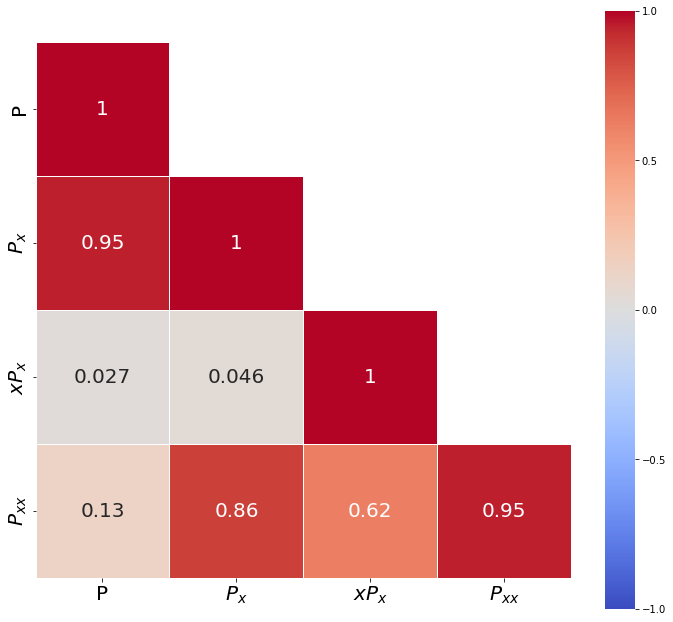

In [143]:
matrix = cc_matrix(Theta[:,1:])
get_lower_tri_heatmap(matrix)


In [56]:
Theta[:,1:].shape

(2280, 4)